# Visualizing ICLR submissions

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import matplotlib as mpl

## Download the data

In [2]:
%%time

import requests

titles = []
abstracts = []
years = []
forum_ids = []
decisions = []
authors = []
keywords = []

# thanks to: https://medium.com/@jasonskessler/how-to-write-a-persuasive-iclr-review-visualizing-the-iclr-2018-review-data-set-a035bf89a946

for year in [2018, 2019, 2020, 2021, 2022, 2023]:
    for query in ['Blind_Submission', 'Withdrawn_Submission', 'Desk_Rejected_Submission']:
        url = f'https://api.openreview.net/notes?invitation=ICLR.cc%2F{year}%2FConference%2F-%2F{query}'
    
        for offset in [0, 1000, 2000, 3000, 4000]:
            print('.', end='')
        
            df = pd.DataFrame(requests.get(url + f'&offset={offset}').json()['notes'])
            if len(df) > 0:
                titles    += [d['title'].strip() for d in df['content'].values]
                abstracts += [d['abstract'].strip() for d in df['content'].values]
                keywords  += [d['keywords'] for d in df['content'].values]
                authors   += [', '.join(d['authors']) for d in df['content']]
                years     += [year] * len(df)
                forum_ids += list(df.forum)
                                                
                if query == 'Withdrawn_Submission':
                    decisions += ['Withdrawn'] * len(df)
                elif query == 'Desk_Rejected_Submission':
                    decisions += ['Desk rejected'] * len(df)
                else:
                    decisions += [''] * len(df)
print('')
print(f'Found {len(titles)} papers')

..........................................................................................
Found 16559 papers
CPU times: user 5.53 s, sys: 276 ms, total: 5.81 s
Wall time: 54.8 s


In [3]:
iclr = pd.DataFrame.from_dict({
    'year': np.array(years).astype(int), 
    'id': forum_ids, 
    'title': titles, 
    'abstract': abstracts,
    'authors': authors,
    'decision': decisions,
    'scores': [[]] * len(abstracts),
    'keywords': [[kk.lower() for kk in k] for k in keywords],
})

# Kicking out nonsense abstracts

mask = np.array([len(a) >= 200 for a in iclr.abstract])
iclr = iclr[mask].reset_index(drop=True)
print(f'Removing {np.sum(~mask)} submissions with abstract length below 200 characters.')

iclr.to_pickle('iclr.pickle.zip')

Removing 23 submissions with abstract length below 200 characters.


<IPython.core.display.Javascript object>


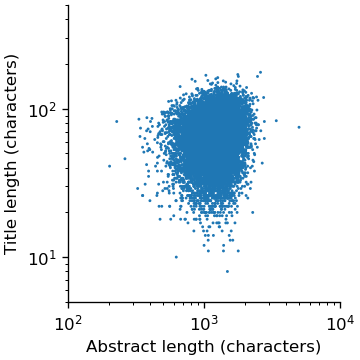

In [4]:
# Sanity check

fig, ax = plt.subplots(figsize=(3, 3), layout='constrained')

len_abstract = [len(a) for a in iclr.abstract]
len_title =    [len(t) for t in iclr.title]

ax.scatter(len_abstract, len_title, s=3, ec='none')
ax.set_xlabel('Abstract length (characters)')
ax.set_ylabel('Title length (characters)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([100, 10000])
ax.set_ylim([5, 500])

sns.despine()

In [17]:
%%time

# Query the accept/reject decisions and scores. Warning: TAKES A COUPLE OF HOURS

for num, forum_id in enumerate(iclr.id):
    if (num + 1) % 1000 == 0:
        print('*', end='')
    elif (num + 1) % 100 == 0:
        print('.', end='')
        
    forum_url = f'https://api.openreview.net/notes?forum={forum_id}'
    json = requests.get(forum_url).json()

    if iclr.decision[num] == '':
        for i in range(len(json['notes'])):
            if 'decision' in json['notes'][i]['content']:
                decision = json['notes'][i]['content']['decision']
        iclr.at[num, 'decision'] = decision
        
    if iclr.decision[num] != 'Desk rejected':
        scores = []
        for i in range(len(json['notes'])):
            if iclr.year[num] < 2023:
                score_field = 'rating'
            else:
                score_field = 'recommendation'
            if score_field in json['notes'][i]['content']:
                score = int(json['notes'][i]['content'][score_field].split(':')[0])
                scores.append(score)
        iclr.at[num, 'scores'] = scores

print('')

iclr.to_pickle('iclr.pickle.zip')

.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.....
CPU times: user 10min 29s, sys: 20.5 s, total: 10min 49s
Wall time: 2h 12min 50s


<IPython.core.display.Javascript object>


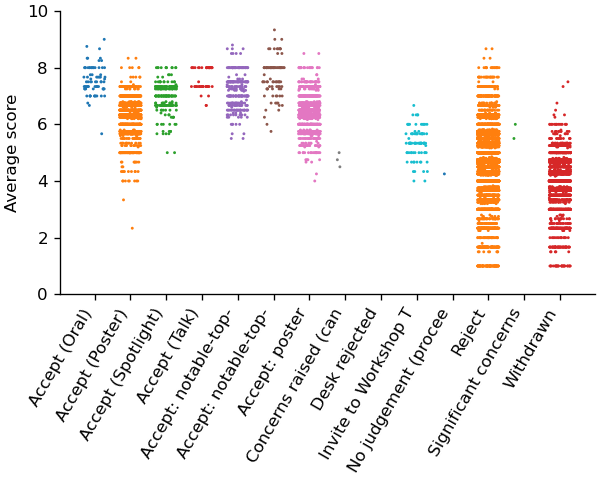

/home/dmitry/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dmitry/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
# Sanity check

fig, ax = plt.subplots(figsize=(5, 4), layout='constrained')

avScores = np.array([np.mean(sc) for sc in iclr.scores])

np.random.seed(42)
for num, decision in enumerate(np.unique(iclr.decision)):
    mask = iclr.decision == decision
    ax.scatter(np.random.uniform(num-.3, num+.3, size=np.sum(mask)), avScores[mask], s=3, ec='none')

ax.set_ylim([0,10])
ax.set_ylabel('Average score')
ax.set_xticks(np.arange(np.unique(iclr.decision).size), 
              [d[:20] for d in np.unique(iclr.decision)], rotation=60, ha='right');

sns.despine()

In [19]:
# Top-scored papers

iclr[avScores > 8.8]

,year,id,title,abstract,authors,decision,scores,keywords
155,2018,Hk6kPgZA-,Certifying Some Distributional Robustness with...,Neural networks are vulnerable to adversarial ...,"Aman Sinha, Hongseok Namkoong, John Duchi",Accept (Oral),"[9, 9, 9]","[adversarial training, distributionally robust..."
12052,2023,Uuf2q9TfXGA,"Understanding Ensemble, Knowledge Distillation...",(this is a theory paper)\n\nWe formally study ...,"Zeyuan Allen-Zhu, Yuanzhi Li",Accept: notable-top-5%,"[8, 10, 10, 8]",[]
12326,2023,88nT0j5jAn,Universal Few-shot Learning of Dense Predictio...,Dense prediction tasks are a fundamental class...,"Donggyun Kim, Jinwoo Kim, Seongwoong Cho, Chon...",Accept: notable-top-5%,"[10, 8, 10]","[few-shot learning, dense prediction tasks]"
12674,2023,lTt4KjHSsyl,Emergence of Maps in the Memories of Blind Nav...,Animal navigation research posits that organis...,"Erik Wijmans, Manolis Savva, Irfan Essa, Stefa...",Accept: notable-top-5%,"[10, 10, 8, 8]","[embodied ai, navigation, characterizing repre..."


In [127]:
# Gave the data to Rita, and she ran the gender inference
# Do not rerun this cell after changing the dataframe (without contacting Rita ;)

# names = [[a.split(',')[0].split()[0], a.split(',')[-1].split()[0]] for a in iclr.authors]
# np.save('names.npy', np.unique(names))

# genders = np.load('genders.npy', allow_pickle=True)

# genderDict = dict(zip(np.unique(names), genders))
# np.save('genderDict.npy', genderDict)

# import pickle

# with open('genderDict.pkl', 'wb') as f:
#     pickle.dump(genderDict, f)

In [20]:
import pickle

with open('genderDict.pkl', 'rb') as f:
    genderDict = pickle.load(f)

names = [[a.split(',')[0].split()[0], a.split(',')[-1].split()[0]] for a in iclr.authors]
names = np.array(names)
inferredGenders = np.zeros_like(names)
for i, name in enumerate(names.flat):
    if name in genderDict:
        inferredGenders.flat[i] = genderDict[name]
    else:
        inferredGenders.flat[i] = 'None'
        
print(f'Inferred {np.mean(inferredGenders != "None") * 100:.1f}% of genders')

iclr['gender-first'] = inferredGenders[:,0]
iclr['gender-last']  = inferredGenders[:,1]

iclr.to_pickle('iclr.pickle.zip')

Inferred 47.6% of genders


In [21]:
iclr

,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last
0,2018,ryBnUWb0b,Predicting Floor-Level for 911 Calls with Neur...,"In cities with tall buildings, emergency respo...","William Falcon, Henning Schulzrinne",Accept (Poster),"[7, 6, 6]","[recurrent neural networks, rnn, lstm, mobile ...",male,None
1,2018,Skk3Jm96W,Some Considerations on Learning to Explore via...,We consider the problem of exploration in meta...,"Bradly Stadie, Ge Yang, Rein Houthooft, Xi Che...",Invite to Workshop Track,"[7, 4, 6]","[reinforcement learning, rl, exploration, meta...",male,male
2,2018,r1RQdCg0W,MACH: Embarrassingly parallel $K$-class classi...,We present Merged-Averaged Classifiers via Has...,"Qixuan Huang, Anshumali Shrivastava, Yiqiu Wang",Reject,"[6, 6, 6]","[extreme classification, large-scale learning,...",None,None
3,2018,rJ3fy0k0Z,Deterministic Policy Imitation Gradient Algorithm,The goal of imitation learning (IL) is to enab...,"Fumihiro Sasaki, Atsuo Kawaguchi",Reject,"[6, 5, 5]",[imitation learning],None,None
4,2018,SkBYYyZRZ,Searching for Activation Functions,The choice of activation functions in deep net...,"Prajit Ramachandran, Barret Zoph, Quoc V. Le",Invite to Workshop Track,"[5, 4, 7]","[meta learning, activation functions]",None,None
...,...,...,...,...,...,...,...,...,...,...
16531,2023,w4eQcMZsJa,Text-Driven Generative Domain Adaptation with ...,Combined with the generative prior of pre-trai...,"Zhenhuan Liu, Liang Li, Jiayu Xiao, Zhengjun Z...",Desk rejected,[],"[gan, stylegan, clip, domain adaptation, style...",None,None
16532,2023,SDHSQuBpf2,"Laziness, Barren Plateau, and Noises in Machin...",We define \emph{laziness} to describe a large ...,"Zexi Lin, Liang Jiang",Desk rejected,[],"[theoretical issues in deep learning, learning...",None,male
16533,2023,HyIY8u5LVDr,Discovering the Representation Bottleneck of G...,Most graph neural networks (GNNs) rely on the ...,"Fang Wu, Siyuan Li, Lirong Wu, Dragomir Radev,...",Desk rejected,[],"[gnn bottleneck, graph rewiring, representatio...",None,male
16534,2023,470wZ5Qk4ur,Results for Perfect Classification for Graph A...,We study the ability of one layer Graph Attent...,"Kimon Fountoulakis, Amit Levi",Desk rejected,[],[],None,male


## Compute t-SNE

In [22]:
iclr = pd.read_pickle('iclr.pickle.zip')

In [6]:
%%time

# TF-IDF (with log-scaling)

from sklearn.feature_extraction.text import TfidfVectorizer

titles_abstracts_together = [iclr.title[i] + ' ' + iclr.abstract[i] for i in range(len(iclr))]

vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_features = vectorizer.fit_transform(titles_abstracts_together)

tfidf_features.shape

CPU times: user 2.18 s, sys: 16 ms, total: 2.19 s
Wall time: 2.22 s


(16536, 34984)

In [7]:
%%time

# SVD

from sklearn.decomposition import TruncatedSVD

# I tried 50, 100, 300, 600 components, and also not using SVD at all.
# 100 components give the most visually "clustered" t-SNE result
# See below

svd = TruncatedSVD(n_components=100, random_state=42, algorithm='arpack')
svd_data = svd.fit_transform(tfidf_features)

svd_data.shape

CPU times: user 20.1 s, sys: 172 ms, total: 20.2 s
Wall time: 5.16 s


(16536, 100)

In [25]:
# t-SNE

from openTSNE import TSNE, affinity

# I tried exaggeration=2 and 4, and visually it did not improve the embedding
# I also tried default affinities, and they give around the same result as uniform ones 

A = affinity.Uniform(svd_data, verbose=True, method='exact', random_state=42, k_neighbors=15)
Z = TSNE(verbose=True, initialization='spectral', random_state=42).fit(affinities=A)

===> Finding 15 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 3.35 seconds
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, initialization='spectral', random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Calculating spectral initialization...
   --> Time elapsed: 0.12 seconds
===> Running optimization with exaggeration=12.00, lr=1378.00 for 250 iterations...
Iteration   50, KL divergence 6.2971, 50 iterations in 0.5471 sec
Iteration  100, KL divergence 6.2876, 50 iterations in 0.5348 sec
Iteration  150, KL divergence 6.2751, 50 iterations in 0.5440 sec
Iteration  200, KL divergence 6.2699, 50 iterations in 0.5349 sec
Iteration  250, KL divergence 6.2813, 50 iterations in 0.5375 sec
   --> Time elapsed: 2.70 seconds
===> Running optimization with exaggeration=1.00, lr=16536.00 for 500 iterations...
Iteration   50, KL div

In [26]:
iclr['t-SNE x'] = Z[:,0].view(np.ndarray)
iclr['t-SNE y'] = Z[:,1].view(np.ndarray)

iclr.to_pickle('iclr.pickle.zip')

In [27]:
iclr

,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,2018,ryBnUWb0b,Predicting Floor-Level for 911 Calls with Neur...,"In cities with tall buildings, emergency respo...","William Falcon, Henning Schulzrinne",Accept (Poster),"[7, 6, 6]","[recurrent neural networks, rnn, lstm, mobile ...",male,None,2.536470,0.739367
1,2018,Skk3Jm96W,Some Considerations on Learning to Explore via...,We consider the problem of exploration in meta...,"Bradly Stadie, Ge Yang, Rein Houthooft, Xi Che...",Invite to Workshop Track,"[7, 4, 6]","[reinforcement learning, rl, exploration, meta...",male,male,49.831927,-29.813831
2,2018,r1RQdCg0W,MACH: Embarrassingly parallel $K$-class classi...,We present Merged-Averaged Classifiers via Has...,"Qixuan Huang, Anshumali Shrivastava, Yiqiu Wang",Reject,"[6, 6, 6]","[extreme classification, large-scale learning,...",None,None,-22.502752,9.577367
3,2018,rJ3fy0k0Z,Deterministic Policy Imitation Gradient Algorithm,The goal of imitation learning (IL) is to enab...,"Fumihiro Sasaki, Atsuo Kawaguchi",Reject,"[6, 5, 5]",[imitation learning],None,None,40.437523,-47.690889
4,2018,SkBYYyZRZ,Searching for Activation Functions,The choice of activation functions in deep net...,"Prajit Ramachandran, Barret Zoph, Quoc V. Le",Invite to Workshop Track,"[5, 4, 7]","[meta learning, activation functions]",None,None,-33.260086,-4.038115
...,...,...,...,...,...,...,...,...,...,...,...,...
16531,2023,w4eQcMZsJa,Text-Driven Generative Domain Adaptation with ...,Combined with the generative prior of pre-trai...,"Zhenhuan Liu, Liang Li, Jiayu Xiao, Zhengjun Z...",Desk rejected,[],"[gan, stylegan, clip, domain adaptation, style...",None,None,59.296526,5.206691
16532,2023,SDHSQuBpf2,"Laziness, Barren Plateau, and Noises in Machin...",We define \emph{laziness} to describe a large ...,"Zexi Lin, Liang Jiang",Desk rejected,[],"[theoretical issues in deep learning, learning...",None,male,-29.178083,-21.810583
16533,2023,HyIY8u5LVDr,Discovering the Representation Bottleneck of G...,Most graph neural networks (GNNs) rely on the ...,"Fang Wu, Siyuan Li, Lirong Wu, Dragomir Radev,...",Desk rejected,[],"[gnn bottleneck, graph rewiring, representatio...",None,male,-7.573978,68.386671
16534,2023,470wZ5Qk4ur,Results for Perfect Classification for Graph A...,We study the ability of one layer Graph Attent...,"Kimon Fountoulakis, Amit Levi",Desk rejected,[],[],None,male,-7.753593,60.764583


### Explore the effect of the SVD dimensionality


In [14]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from openTSNE import TSNE, affinity

titles_abstracts_together = [iclr.title[i] + ' ' + iclr.abstract[i] for i in range(len(iclr))]
vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_features = vectorizer.fit_transform(titles_abstracts_together)

n_pcs = [50, 100, 200, 300, 600, tfidf_features.shape[1]]

Zs = []
for num, n_pc in enumerate(n_pcs):
    if n_pc < tfidf_features.shape[1]:
        svd = TruncatedSVD(n_components=n_pc, random_state=42, algorithm='arpack')
        x = svd.fit_transform(tfidf_features)
    else:
        x = tfidf_features
    
    A = affinity.Uniform(x, method='exact', random_state=42, k_neighbors=15)
    Z = TSNE(initialization='spectral', random_state=42).fit(affinities=A)
    Zs.append(Z)

CPU times: user 15min 31s, sys: 37.4 s, total: 16min 8s
Wall time: 8min 26s


<IPython.core.display.Javascript object>


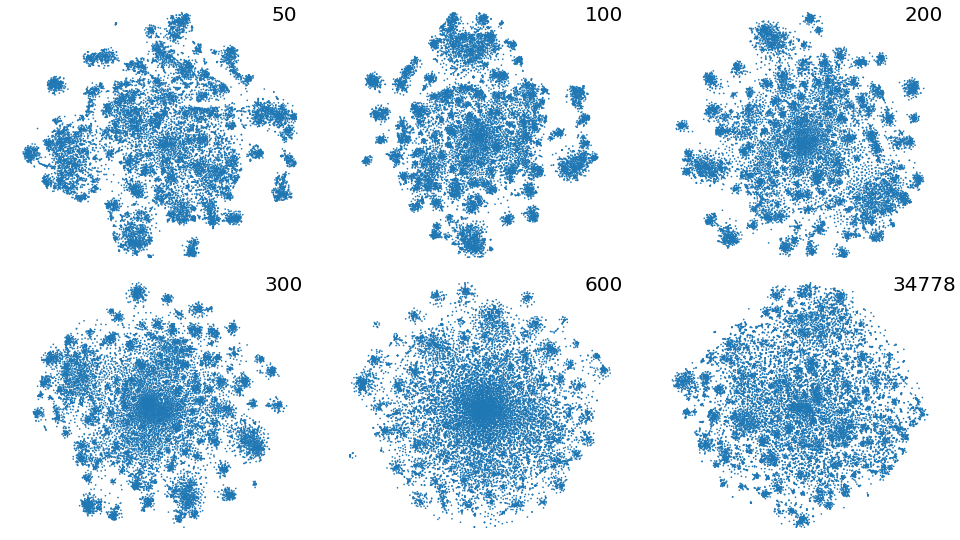

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 4.5), layout='constrained')

for num, n_pc in enumerate(n_pcs):
    axs.flat[num].axis('equal')
    axs.flat[num].scatter(*Zs[num].T, s=1, ec='none')
    axs.flat[num].set_xticks([])
    axs.flat[num].set_yticks([])
    axs.flat[num].set_title(n_pc, x=.9, y=.9)
sns.despine(left=True, bottom=True)

fig.savefig('svd-effect.png', dpi=200)

## Make pretty figures

In [2]:
iclr = pd.read_pickle('iclr.pickle.zip')

Z = iclr[['t-SNE x', 't-SNE y']].values

In [18]:
# Most frequent keywords

keywords, counts = np.unique(np.concatenate(iclr.keywords.values), return_counts=True)
ind = np.argsort(counts)[::-1][:20]
for i in ind:
    if len(keywords[i]) >= 5: 
        print(f'{keywords[i]:30} {counts[i]:4}')
print('')

deep learning                  1402
reinforcement learning         1177
representation learning         605
graph neural networks           373
self-supervised learning        335
generalization                  315
robustness                      310
neural networks                 296
federated learning              293
unsupervised learning           283
transfer learning               273
generative models               269
optimization                    263
meta-learning                   260
natural language processing     259
computer vision                 240
deep reinforcement learning     234
transformer                     233
interpretability                233
continual learning              223



In [16]:
# Most frequent words in the titles (at least 5 letters)

words, counts = np.unique(' '.join(iclr.title).lower().split(), return_counts=True)
ind = np.argsort(counts)[::-1][:30]
for i in ind:
    if len(words[i]) >= 5: 
        print(f'{words[i]:20} {counts[i]:4}')

learning             4991
neural               2375
networks             1952
reinforcement         926
models                907
adversarial           892
graph                 869
training              738
network               683
using                 612
representation        612
model                 562
optimization          519
efficient             506
generative            486
representations       472


In [21]:
keywords = ['network', 'graph', 'reinforcement', 'language', 'adversarial', 
            'federated','contrastive', 'domain', 'diffusion', 'out-of-dis',
            'continual', 'distillation', 'architecture', 'privacy',
            'protein', 'fair', 'attention', 'video', 'meta-learning',
            'generative adv', 'autoencoder', 'game', 'semi-sup',
            'pruning', 'physics', '3d', 'translation', 'optimization',
            'recurrent', 'word', 'bayesian']
keywords = np.array(keywords)

# glasbey.create_palette(palette_size=32)
labelColors = ['#d21820', '#1869ff', '#008a00', '#f36dff', '#710079', '#aafb00', 
               '#00bec2', '#ffa235', '#5d3d04', '#08008a', '#005d5d', '#9a7d82', 
               '#a2aeff', '#96b675', '#9e28ff', '#4d0014', '#ffaebe', '#ce0092', 
               '#00ffb6', '#002d00', '#9e7500', '#3d3541', '#f3eb92', '#65618a', 
               '#8a3d4d', '#5904ba', '#558a71', '#b2bec2', '#ff5d82', '#1cc600', 
               '#92f7ff', '#2d86a6']
labelColors = np.array(labelColors)

counts = [np.sum([keyword in t.lower() for t in iclr.title]) for keyword in keywords]
ind = np.argsort(counts)[::-1][:30]
for i in ind:
    print(f'{keywords[i]:20} {counts[i]:4}')
    
print('')
print(f'{keywords.size} labels')

network              2775
graph                1087
reinforcement         948
adversarial           922
optimization          541
language              524
domain                398
attention             341
federated             334
contrastive           300
architecture          270
autoencoder           214
continual             202
video                 195
3d                    194
distillation          174
translation           171
bayesian              170
recurrent             170
semi-sup              162
pruning               155
diffusion             152
meta-learning         152
generative adv        136
fair                  132
game                  130
out-of-dis            128
privacy               105
word                   98
physics                79

31 labels


<IPython.core.display.Javascript object>


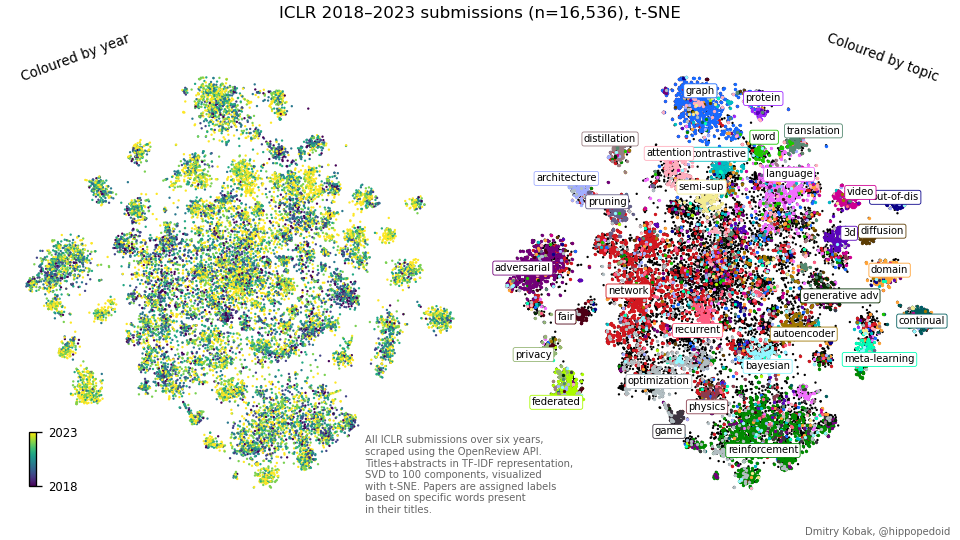

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4.5), layout='constrained')

axs[0].axis('equal')
reorder = np.random.permutation(Z.shape[0])
sc = axs[0].scatter(Z[reorder,0], Z[reorder,1], s=2, c=iclr.year[reorder], ec='none')
axs[0].set_xticks([])
axs[0].set_yticks([])

axclb = plt.axes([.03,.1,.008,.1])
cb = fig.colorbar(sc, cax=axclb, ticks=[2018,2023])
cb.ax.tick_params(labelsize=7)

axs[1].axis('equal')
axs[1].scatter(Z[:,0], Z[:,1], s=2, c='k', ec='none')
axs[1].set_xticks([])
axs[1].set_yticks([])

for num, keyword in enumerate(keywords):
    ind = [i for i,t in enumerate(iclr.title) if keyword.lower() in t.lower()]
    axs[1].scatter(Z[ind,0], Z[ind,1], s=1, c=labelColors[num])

from sklearn.neighbors import KernelDensity
for num, keyword in enumerate(keywords):
    ind = [keyword.lower() in t.lower() for t in iclr.title]
    if np.sum(ind) > 500:
        bw = 10
    else:
        bw = 2    
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(Z[ind])
    log_density = kde.score_samples(Z[ind])
    mode = Z[ind][np.argmax(log_density)]
    mode += mode / np.linalg.norm(mode) * 5
    if keyword == 'translation':
        mode[0] += 5
    if mode[0] > 65:
        mode[0] -= 5
    axs[1].text(mode[0], mode[1], keyword, ha='center', va='center', c='k', fontsize=6,
                bbox=dict(facecolor='w', alpha=1, edgecolor=labelColors[num], 
                          boxstyle='round, pad=.2', linewidth=.5))
    
sns.despine(left=True, bottom=True)
fig.suptitle(f'ICLR 2018–2023 submissions (n={len(iclr):,}), t-SNE', fontsize=10)
fig.text(.02, .85, 'Coloured by year',  fontsize=8, rotation=20)
fig.text(.98, .85, 'Coloured by topic', fontsize=8, rotation=-20, ha='right')

fig.text(.99, .01, 'Dmitry Kobak, @hippopedoid', fontsize=6, ha='right', color='#666666')

fig.text(.38, .05, '''
All ICLR submissions over six years,
scraped using the OpenReview API.
Titles+abstracts in TF-IDF representation,
SVD to 100 components, visualized 
with t-SNE. Papers are assigned labels
based on specific words present 
in their titles.''', fontsize=6, color='#666666')

fig.savefig('iclr-all.png', dpi=300)

#################################################################
# Code below allows interactive exploration
#################################################################

# txt = fig.text(.02, .8, "")
# txt.set_visible(False)

# def update_annot(ind):
# #     pos = sc.get_offsets()[ind["ind"][0]]
#     text = iclr.title.values[reorder][ind["ind"][0]]
#     txt.set_text(text)

# def hover(event):
#     vis = txt.get_visible()
#     if event.inaxes == axs[0]:
#         cont, ind = sc.contains(event)
#         if cont:
#             update_annot(ind)
#             txt.set_visible(True)
#             fig.canvas.draw_idle()
#         else:
#             if vis:
#                 txt.set_visible(False)
#                 fig.canvas.draw_idle()

# fig.canvas.mpl_connect("motion_notify_event", hover)

<IPython.core.display.Javascript object>


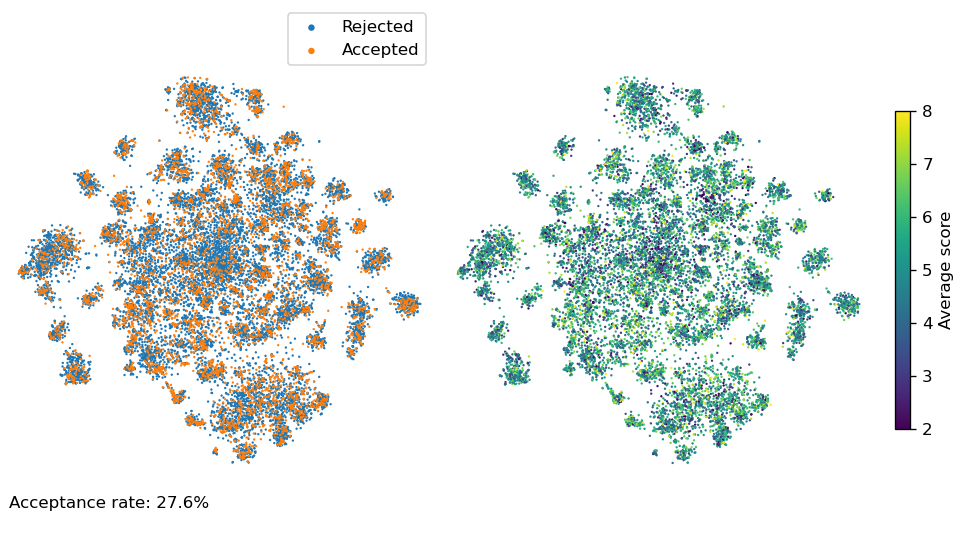

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4.5), layout='constrained')

accepted = np.array([d[:3]=='Acc' for d in iclr.decision])

accepted_rate = np.mean(accepted) * 100
axs[0].text(.01, .05, f'Acceptance rate: {accepted_rate:.1f}%', transform=axs[0].transAxes)

np.random.seed(42)
ra  = np.random.permutation(Z[ accepted].shape[0])
rna = np.random.permutation(Z[~accepted].shape[0])

axs[0].axis('equal')
axs[0].scatter(*Z[~accepted].T,    s=2, ec='none', label='Rejected')
axs[0].scatter(*Z[accepted][ra].T, s=2, ec='none', label='Accepted')

lgnd = axs[0].legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([15])

axs[0].set_xticks([])
axs[0].set_yticks([])


avScore = np.array([np.mean(sc) for sc in iclr.scores])

axs[1].axis('equal')
sc = axs[1].scatter(*Z.T, c=avScore, s=2, ec='none', vmax=8, vmin=2)

fig.colorbar(sc, label='Average score', shrink=.6)

axs[1].set_xticks([])
axs[1].set_yticks([])

sns.despine(left=True, bottom=True)
fig.savefig('iclr-acceptance-scores.png', dpi=200)

<IPython.core.display.Javascript object>


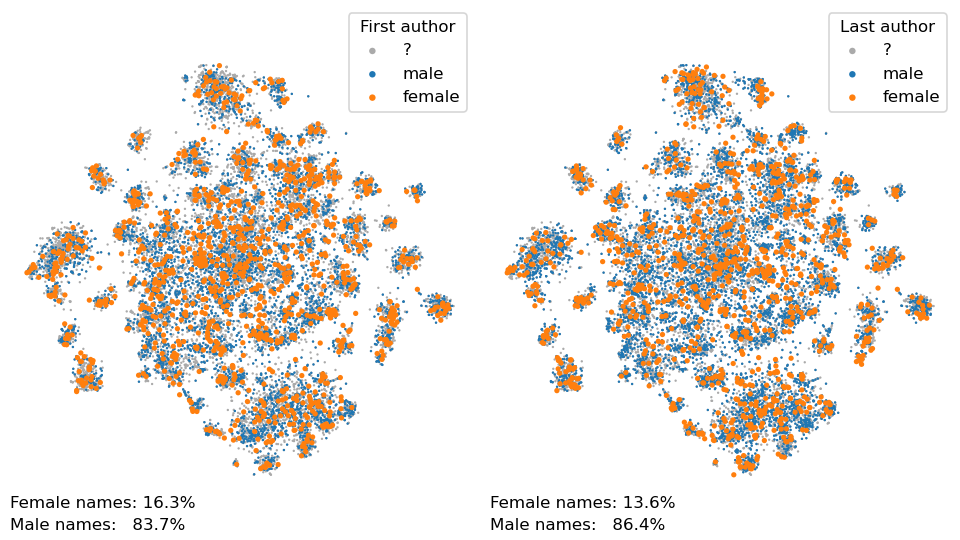

In [34]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4.5), layout='constrained')

inferredGenders = iclr[['gender-first', 'gender-last']].values
femaleRatios =  np.sum(inferredGenders == 'female', axis=0).astype(float)
femaleRatios /= np.sum(np.isin(inferredGenders, ['male', 'female']), axis=0)
femaleRatios *= 100

which = ['First', 'Last']
for num, genders in enumerate(iclr[['gender-first', 'gender-last']].values.T):
    axs[num].axis('equal')
    axs[num].scatter(*Z.T, s=2, c='#aaaaaa', ec='none', label='?')
    axs[num].scatter(*Z[genders=='male'].T, s=2, ec='none', label='male')
    axs[num].scatter(*Z[genders=='female'].T, s=10, ec='none', label='female')

    lgnd = axs[num].legend(title=f'{which[num]} author', loc='upper right')
    for handle in lgnd.legendHandles:
        handle.set_sizes([15])

    axs[num].set_xticks([])
    axs[num].set_yticks([])
    
    axs[num].text(.01, .05, f'Female names: {femaleRatios[num]:.1f}%', transform=axs[num].transAxes)
    axs[num].text(.01, .01, f'Male names:   {100-femaleRatios[num]:.1f}%', transform=axs[num].transAxes)

sns.despine(left=True, bottom=True)
fig.savefig('iclr-genders.png', dpi=200)

<IPython.core.display.Javascript object>


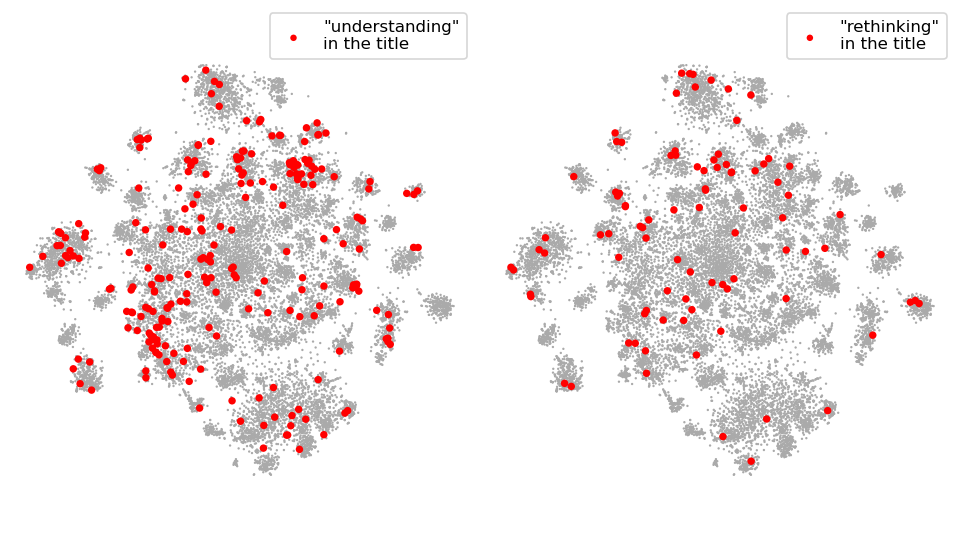

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4.5), layout='constrained')

words = ['understanding', 'rethinking']

for num, word in enumerate(words):
    mask = np.array([word in d.lower() for d in iclr.title])

    axs[num].axis('equal')
    axs[num].scatter(Z[~mask,0], Z[~mask,1], s=2,  ec='none', c='#aaaaaa')
    axs[num].scatter(Z[mask,0], Z[mask,1],   s=20, ec='none', c='r', label=f'"{word}"\nin the title')

    lgnd = axs[num].legend()
    for handle in lgnd.legendHandles:
        handle.set_sizes([15])

    axs[num].set_xticks([])
    axs[num].set_yticks([])

sns.despine(left=True, bottom=True)
fig.savefig('iclr-rethinking.png', dpi=200)

<IPython.core.display.Javascript object>


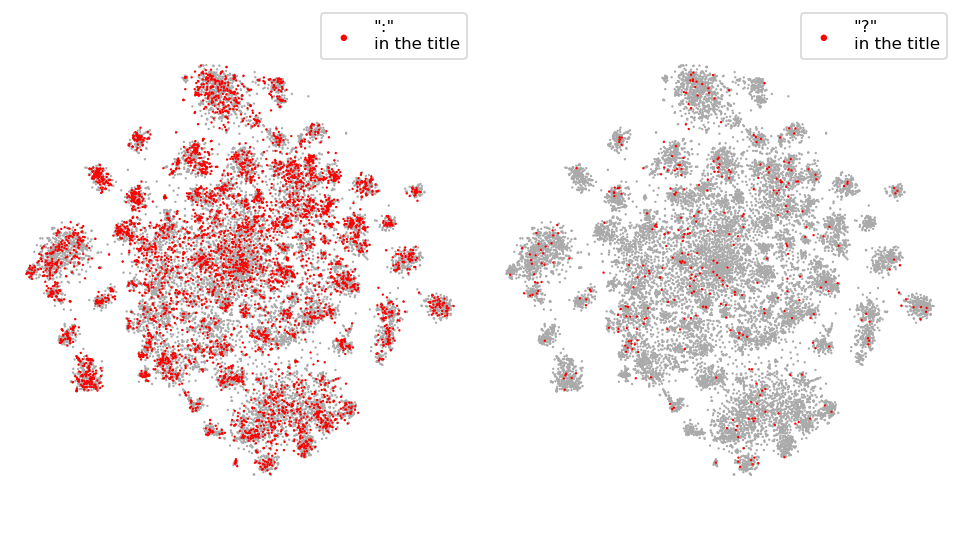

In [123]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4.5), layout='constrained')

chars = [':', '?']

for num, char in enumerate(chars):
    mask = np.array([char in t for t in iclr.title])

    axs[num].axis('equal')
    axs[num].scatter(Z[~mask,0], Z[~mask,1], s=2,  ec='none', c='#aaaaaa')
    axs[num].scatter(Z[mask,0], Z[mask,1],   s=2, ec='none', c='r', label=f'"{char}"\nin the title')

    lgnd = axs[num].legend()
    for handle in lgnd.legendHandles:
        handle.set_sizes([15])

    axs[num].set_xticks([])
    axs[num].set_yticks([])

sns.despine(left=True, bottom=True)
# fig.savefig('iclr-rethinking.png', dpi=200)

<IPython.core.display.Javascript object>


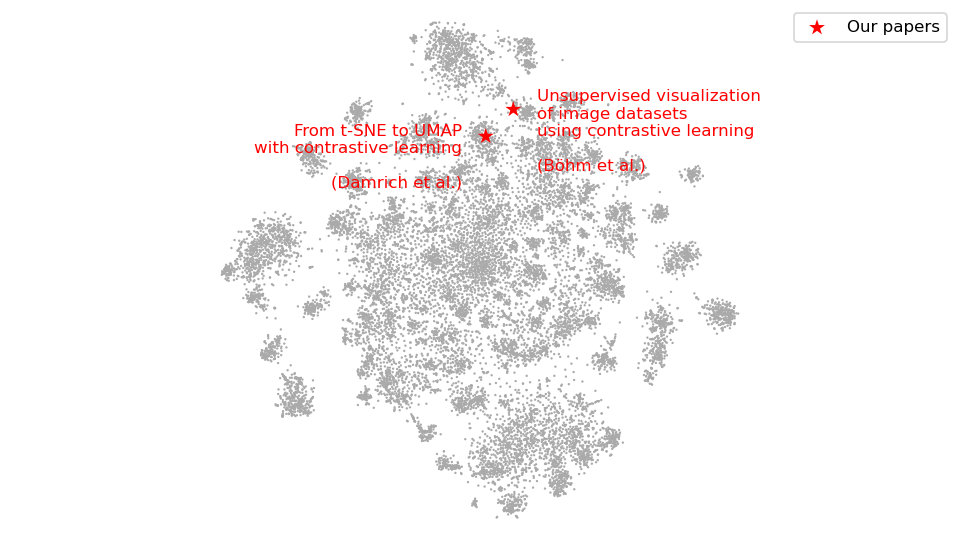

In [27]:
fig, ax = plt.subplots(figsize=(8, 4.5), layout='constrained')

mask = np.array(['umap with contrastive' in d.lower() or 
                 'image datasets using contrastive' in d.lower() 
                 for d in iclr.title])

ax.axis('equal')
ax.scatter(*Z[~mask].T, s=2,  ec='none', c='#aaaaaa')
ax.scatter(*Z[mask].T,  s=100, ec='none', c='r', marker='*', label=f'Our papers')

lgnd = ax.legend()

ax.text(17, 30, "Unsupervised visualization\nof image datasets\nusing contrastive learning\n\n(Böhm et al.)", 
        color='red')

ax.text(-5, 25, "From t-SNE to UMAP\nwith contrastive learning\n\n(Damrich et al.)", 
        color='red', ha='right')

ax.set_xticks([])
ax.set_yticks([])
sns.despine(left=True, bottom=True)
fig.savefig('iclr-ours.png', dpi=200)

In [3]:
all_authors = ', '.join(list(iclr.authors)).split(', ')
authors, counts = np.unique(all_authors, return_counts=True)

ind = np.argsort(counts)[::-1]
for i in ind[:10]:
    print(f'{authors[i]:20} {counts[i]}')
    
top_authors = authors[ind]

Sergey Levine        141
Yoshua Bengio        112
Pieter Abbeel        83
Tom Goldstein        77
Zhangyang Wang       76
Cho-Jui Hsieh        62
Dacheng Tao          61
Chelsea Finn         61
Bo Li                60
Jun Wang             60


<IPython.core.display.Javascript object>


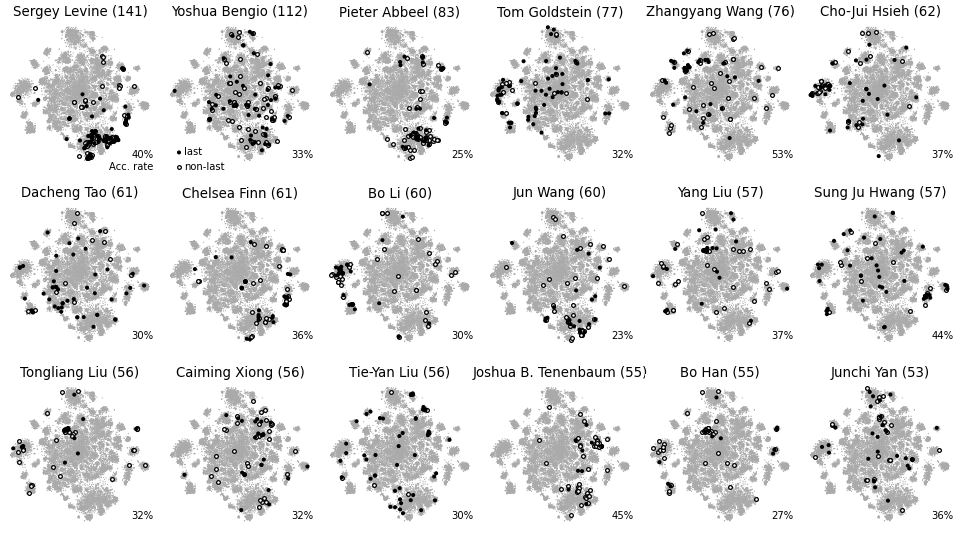

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(8, 4.5), layout='constrained')

for num, author in enumerate(top_authors[:18]):
    mask = [author in a.split(', ') for a in iclr.authors]
    mask_last = [a[-len(author):]==author for a in iclr.authors]
    mask_nonlast = np.array(mask) & ~np.array(mask_last)
    
    axs.flat[num].axis('equal')
    axs.flat[num].scatter(*Z.T, s=.5, ec='none', c='#aaaaaa')
    axs.flat[num].scatter(*Z[mask_last].T, s=6, ec='none', c='k', label='last', zorder=2)
    axs.flat[num].scatter(*Z[mask_nonlast].T, s=5, ec='k', c='w', lw=.75, label='non-last')
    
    if num==1:
        axs.flat[num].legend(frameon=False, fontsize=6, loc=(0,-0.01), handletextpad=-0.5)

    axs.flat[num].set_xticks([])
    axs.flat[num].set_yticks([])
    axs.flat[num].set_title(f'{author} ({np.sum(mask)})', fontsize=8, y=.92)
    
    accepted = np.array([d[:6]=='Accept' for d in iclr.decision])
    acceptance_rate = np.mean(accepted[mask]) * 100
    axs.flat[num].text(.99, .1, f'{acceptance_rate:.0f}%', fontsize=6, 
                       ha='right', transform=axs.flat[num].transAxes)
    if num==0:
        axs.flat[num].text(.99, .03, 'Acc. rate', fontsize=6,
                       ha='right', transform=axs.flat[num].transAxes)

sns.despine(left=True, bottom=True)
fig.savefig('iclr-authors.png', dpi=200)